# Taxi-v3 project

## Methods and variables in DiscreteEnv class

variables: <br>

nS -- Number of states <br>
nA -- Number of Actions <br>
lastaction -- Last action taken (Set when Step() is called) <br>
P -- State-transitions table -- probility table for occurence of a state from previous state and action pair <br>
isd -- initial State distribution -- This is the probability distribution to set the initial state when reset() is called <br>
action_space -- This is the Discrete space of actions 
observation_space -- This is the Discrete space of states

Methods: <br>

reset() -- To reset the Discrete Env class and returns initial state according to isd variable <br>
step() -- This function takes action index as input and returns next_state, reward, done flag and <br> 
          dictionary with probability from state transitition table (P) <br>


## Methods and variables in Taxi-v3 class

variables: <br>
locs : eligible locations where passengers can be picked up or dropped off.

Methods: <br>

render() : This functions displays the Map and actions taken <br>
endode() : This function is used for creating the state which in this case is a mixture of taxi location, pass location and destination location <br>
decode() : This function is split the state into taxi location, pass location and destination location


## Taxi-v3 problem 

There are four locations in the environment where a passenger can be picked up or dropped off represented by (R, G, Y, B). Problem is about pick up the passenger and drop off passenger using the shortest path.

### Episode Generation

For each episode, passenger pick-up and dropped off location chosen randomly and also taxi location is changed randomly.

### Reward Structure. 

For each illegal pickup or drop off, there is penality of -10. <br> 
For successful drop off, there is a reward of +20. <br>
For any other step, there is reward of -1. <br>

### Actions

Actions that can be performed and corresponding action index are <br>

move south  : 0 <br>
move north  : 1 <br>
move east   : 2 <br>
move west   : 3 <br>
pick up     : 4 <br>
drop off    : 5 <br>

### States

In this problem, states is dependent on taxi location, passenger location and destination location. <br>

Possible passenger location and their indexes: <br>

Red (R)     : 0 <br>
Green (G)   : 1 <br>
Yellow (Y)  : 2 <br>
Blue (B)    : 3 <br>
In Taxi     : 4 <br>

Possbile Destination location and their indexes: <br>

Red (R)     : 0 <br>
Green (G)   : 1 <br>
Yellow (Y)  : 2 <br>
Blue (B)    : 3 <br>

The Map is 5 x 5 dimension and taxi location can take up to 25 possible location starting from (0, 0) to (4 , 4)

Total Number of states = (taxi locations) * (passenger locations) * (destination location) = 25 \* 5 \* 4 = 500 

### Render 

When you call render function, color of the taxi and designated locations represent as below: <br>

blue    : Represents passenger location <br>
magenta : Represent the destination location <br>
yellow  : Empty taxi
green   : Full taxi

R , G, Y, B letters represent the possible locations for passenger pick up or drop off


## Install dependencies

In [9]:
import gym
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

## To load the taxi Environment and helper function to solve the problem

In [11]:
taxi = gym.make('Taxi-v3')

In [12]:
state = taxi.reset()
taxi.render()


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [13]:
def epsilon_greedy_action(table, state, epsilon):
    action_probs = np.asarray([epsilon / taxi.nA] * taxi.nA, dtype = np.float)
    greedy_action_index = np.argmax(table.loc[state].values)
    action_probs[greedy_action_index] += (1 - epsilon)
    return np.random.choice(range(taxi.nA), p=action_probs)

In [15]:
# Q-Learning
def Qlearn_estimated_returns_function(n_episodes, alpha = 0.1, gamma = 0.9, epsilon_decay = 0.999, min_epsilon = 0.1):
    cumulative_rewards_array = []
    error_convergence = []
    ESTIMATED_RETURNS_TBL = pd.DataFrame.from_dict({s: {a: 0 for a in range(taxi.nA)} for s in range(taxi.nS)}, orient='index')
    epsilon = 1

    for i in tqdm(range(n_episodes)):
        s0 = taxi.reset()
        epsilon = max(epsilon, min_epsilon)
        estimated_returns = ESTIMATED_RETURNS_TBL
        estimated_returns_copy = ESTIMATED_RETURNS_TBL.copy()
        done = False
        cumulative_reward = 0

        while not done:
            a0 = epsilon_greedy_action(estimated_returns, s0, epsilon)
            s1, reward, done, prob_dict = taxi.step(a0)
            estimated_returns.loc[s0, a0] += alpha * (reward + gamma * estimated_returns.loc[s1].max() - estimated_returns.loc[s0, a0])
            cumulative_reward += reward 
            s0 = s1

        epsilon *= epsilon_decay

        error = (estimated_returns - estimated_returns_copy).abs().mean().mean()
        error_convergence.append(error)
        #print('total reward for this episode: {}'.format(cumulative_reward))
        cumulative_rewards_array.append(cumulative_reward)

        if i % 500 == 0:
            print('Iteration : {}'.format(_))
            print('Error: {}'.format(error))
    
    return ESTIMATED_RETURNS_TBL, error_convergence, cumulative_rewards_array

In [38]:
estimated_returns_qlearn, error_qlearn, rewards_array_qlearn = Qlearn_estimated_returns_function(3000, alpha = 0.2, gamma = 0.9)

  0%|          | 3/3000 [00:00<05:28,  9.12it/s]Iteration : 15
Error: 0.0345285554688
 17%|█▋        | 503/3000 [00:44<03:34, 11.62it/s]Iteration : 15
Error: 0.004590991941357651
 34%|███▍      | 1014/3000 [00:59<00:33, 60.10it/s]Iteration : 15
Error: 0.0004784394910211871
 51%|█████     | 1519/3000 [01:06<00:14, 101.63it/s]Iteration : 15
Error: 0.0005801326753342217
 67%|██████▋   | 2015/3000 [01:11<00:09, 99.28it/s] Iteration : 15
Error: 0.00012754465703311219
 84%|████████▍ | 2520/3000 [01:16<00:04, 108.85it/s]Iteration : 15
Error: 6.527809547040805e-05
100%|██████████| 3000/3000 [01:21<00:00, 36.98it/s] 


In [39]:
def reward_array(table, episodes):
    return_array = []

    for i in tqdm(range(episodes)):
        s0 = taxi.reset()
        done = False
        total_reward = 0

        while not done:
            a0 = np.argmax(table.loc[s0].values)
            s1, reward, done, prob_dict = taxi.step(a0)
            total_reward += reward
            if (reward == -10):
                assert 'illegal step taken, train more'
            #taxi.render()
            s0 = s1

        return_array.append(total_reward)
    return return_array

100%|██████████| 1000/1000 [00:01<00:00, 716.85it/s]


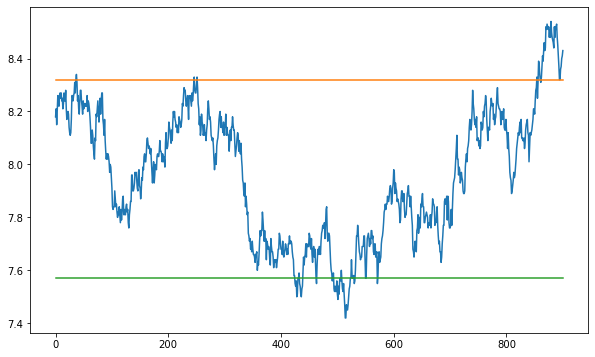

In [41]:
test_rewards_array_qlearn = reward_array(estimated_returns_qlearn, 1000)
plt.figure(figsize=(10, 6))
test_average_rewards_qlearn = np.convolve(np.array(test_rewards_array_qlearn, dtype = np.float), np.ones(100), mode='valid')
test_average_rewards_qlearn /= 100
plt.plot(test_average_rewards_qlearn)
plt.plot([np.percentile(test_average_rewards_qlearn, 95)] * len(test_average_rewards_qlearn))
plt.plot([np.percentile(test_average_rewards_qlearn, 5)] * len(test_average_rewards_qlearn))

## How Hyper-parameters are chosen

At first, I have compared the Qlearn with sarsa and sarsa convergence is not good compared to Qlearn.<br>
I have also compared Qlearn with bfs and the Qlearn performs exactly same as bfs with the above set of hyper-parameters.<br>
I have observed the average_reward graph of Qlearn and after 2500 episodes average-reward became constant.<br>
I have checked various alpha values and compared with bfs. alpha=0.2 performed well with 3000 episodes. Below 3000 episodes all values of alpha didn't worked well.

Below you can see the experiments I have performed.


In [42]:
#SARSA 
def sarsa_estimated_returns_function(n_episodes, alpha = 0.1, gamma = 0.9, epsilon_decay = 0.999, min_epsilon = 0.1):
    cumulative_rewards_array = []
    error_convergence = []
    ESTIMATED_RETURNS_TBL = pd.DataFrame.from_dict({s: {a: 0 for a in range(taxi.nA)} for s in range(taxi.nS)}, orient='index')
    epsilon = 1

    for _ in tqdm(range(n_episodes)):
        s0 = taxi.reset()
        epsilon = max(epsilon, min_epsilon)
        estimated_returns = ESTIMATED_RETURNS_TBL
        a0 = epsilon_greedy_action(estimated_returns, s0, epsilon)
        estimated_returns_copy = ESTIMATED_RETURNS_TBL.copy()
        done = False
        cumulative_reward = 0

        while not done:
            s1, reward, done, prob_dict = taxi.step(a0)
            a1 = epsilon_greedy_action(estimated_returns, s1, epsilon)
            estimated_returns.loc[s0, a0] += alpha * (reward + gamma * estimated_returns.loc[s1, a1] - estimated_returns.loc[s0, a0])
            cumulative_reward += reward 
            s0, a0 = s1, a1
            
        epsilon *= epsilon_decay

        error = (estimated_returns - estimated_returns_copy).abs().mean().mean()
        error_convergence.append(error)
        #print('total reward for this episode: {}'.format(cumulative_reward))
        cumulative_rewards_array.append(cumulative_reward)

        if _ % 500 == 0:
            print('Iteration : {}'.format(_))
            print('Error: {}'.format(error))
    
    return ESTIMATED_RETURNS_TBL, error_convergence, cumulative_rewards_array


In [43]:
estimated_returns_qlearn, error_qlearn, rewards_array_qlearn = Qlearn_estimated_returns_function(10000, alpha = 0.2, gamma = 0.9)
estimated_returns_sarsa, error_sarsa, rewards_array_sarsa = sarsa_estimated_returns_function(10000, alpha = 0.2, gamma = 0.9)

  0%|          | 2/10000 [00:00<20:22,  8.18it/s]Iteration : [<matplotlib.lines.Line2D object at 0x0000013CBCA3ED30>]
Error: 0.03319861170244267
  5%|▌         | 505/10000 [00:42<05:55, 26.73it/s]Iteration : [<matplotlib.lines.Line2D object at 0x0000013CBCA3ED30>]
Error: 0.011386955491700122
 10%|█         | 1013/10000 [00:52<02:03, 72.94it/s]Iteration : [<matplotlib.lines.Line2D object at 0x0000013CBCA3ED30>]
Error: 0.0012629230736273462
 15%|█▌        | 1519/10000 [00:59<01:34, 89.54it/s]Iteration : [<matplotlib.lines.Line2D object at 0x0000013CBCA3ED30>]
Error: 7.845784242150788e-05
 20%|██        | 2016/10000 [01:04<01:19, 100.81it/s]Iteration : [<matplotlib.lines.Line2D object at 0x0000013CBCA3ED30>]
Error: 0.00014182262614590826
 25%|██▌       | 2515/10000 [01:08<01:13, 102.00it/s]Iteration : [<matplotlib.lines.Line2D object at 0x0000013CBCA3ED30>]
Error: 0.0001914452059870596
 30%|███       | 3014/10000 [01:13<01:04, 108.28it/s]Iteration : [<matplotlib.lines.Line2D object at 0x0

100%|██████████| 1000/1000 [00:01<00:00, 598.45it/s]


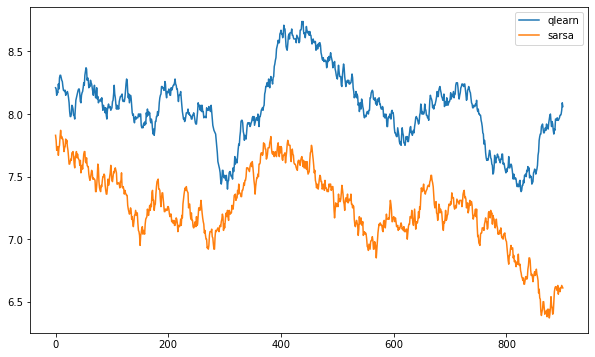

In [44]:
test_rewards_array_qlearn = reward_array(estimated_returns_qlearn, 1000)
test_rewards_array_sarsa = reward_array(estimated_returns_sarsa, 1000)

plt.figure(figsize=(10, 6))
test_average_rewards_qlearn = np.convolve(np.array(test_rewards_array_qlearn, dtype = np.float), np.ones(100), mode='valid')
test_average_rewards_qlearn /= 100
test_average_rewards_sarsa = np.convolve(np.array(test_rewards_array_sarsa, dtype = np.float), np.ones(100), mode='valid')
test_average_rewards_sarsa /= 100
plt.plot(test_average_rewards_qlearn)
plt.plot(test_average_rewards_sarsa)
plt.legend(['qlearn', 'sarsa'])


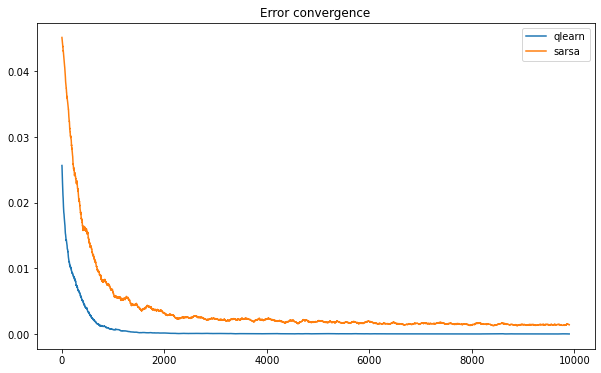

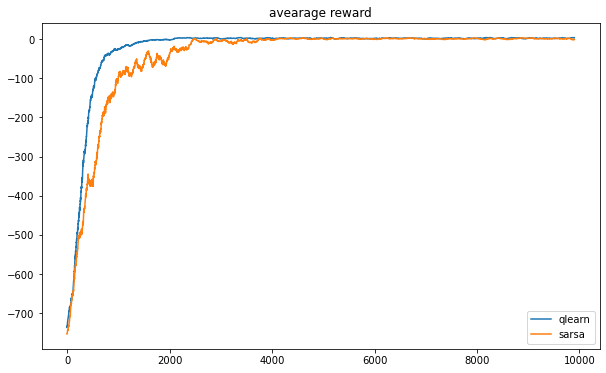

In [45]:
plt.figure(figsize=(10,6))
plt.title('Error convergence')
error_array_qlearn = np.array(error_qlearn, dtype=np.float)
average_error_qlearn = np.convolve(error_array_qlearn.flatten(), np.ones(100), mode='valid')
average_error_qlearn /= 100
error_array_sarsa = np.array(error_sarsa, dtype=np.float)
average_error_sarsa = np.convolve(error_array_sarsa.flatten(), np.ones(100), mode='valid')
average_error_sarsa /= 100
plt.plot(average_error_qlearn)
plt.plot(average_error_sarsa)
plt.legend(['qlearn', 'sarsa'])


plt.figure(figsize=(10,6))
plt.title('avearage reward')
rewards_np_array_sarsa = np.array(rewards_array_sarsa, dtype = np.float)
average_rewards_sarsa = np.convolve(rewards_np_array_sarsa.flatten(), np.ones(100), mode = 'valid')
average_rewards_sarsa /= 100
rewards_np_array_qlearn = np.array(rewards_array_qlearn, dtype = np.float)
average_rewards_qlearn = np.convolve(rewards_np_array_qlearn.flatten(), np.ones(100), mode = 'valid')
average_rewards_qlearn /= 100
plt.plot(average_rewards_qlearn)
plt.plot(average_rewards_sarsa)
plt.legend(['qlearn', 'sarsa'])

## Qlearn vs Sarsa

With same set of params Qlearn seems converge better than sarsa

In [46]:
def new_coordinates(x, y, action):
    new_x = x
    new_y = y

    if (action == 0):
        new_x = x + 1
    elif (action == 1):
        new_x = x - 1
    elif (action == 2):
        new_y = y + 1
    elif (action == 3):
        new_y = y - 1
    
    return new_x, new_y

def bfs(penality_array, pass_loc, pass_idx):
    queue = []
    visited_array = np.zeros((5,5))
    visited_array[pass_loc[0], pass_loc[1]] = 1
    queue.append((pass_loc[0], pass_loc[1]))

    while len(queue) != 0:
        x, y = queue.pop(0)

        for act in range(4):
            new_x, new_y = new_coordinates(x, y, act)

            if new_x >= 5 or new_x < 0:
                continue
            if new_y >= 5 or new_y < 0:
                continue
            if act == 2 and taxi.desc[1 + x, 2 * y + 2] == b"|":
                continue
            if act == 3 and taxi.desc[1 + x, 2 * y] == b"|":
                continue
            if visited_array[new_x, new_y] != 0:
                continue
            
            visited_array[new_x, new_y] = 1
            penality_array[pass_idx][new_x * 5 + new_y] = penality_array[pass_idx][x * 5 + y] - 1
            queue.append((new_x, new_y))


In [47]:
penality_array = np.zeros((4, 25), dtype = np.int)

for i in range(len(taxi.locs)):
    bfs(penality_array, taxi.locs[i], i)

print(penality_array[0].reshape(5,5))

[[ 0 -1 -6 -7 -8]
 [-1 -2 -5 -6 -7]
 [-2 -3 -4 -5 -6]
 [-3 -4 -5 -6 -7]
 [-4 -5 -6 -7 -8]]


In [48]:
def return_reward_from_bfs(state):
    taxi_row, taxi_col, pass_idx, dest_idx = taxi.decode(state)

    total_reward = 0
    total_reward += penality_array[pass_idx][taxi_row * 5 + taxi_col]
    pass_row,pass_col = taxi.locs[pass_idx]
    total_reward += penality_array[dest_idx][pass_row * 5 + pass_col]

    total_reward -= 1
    total_reward += 20

    return total_reward

In [49]:
state = taxi.encode(0, 0, 0, 2)
return_reward_from_bfs(state)

15

In [50]:
def compare_bfs_with_qlearn(table, episodes):
    bfs_reward_array = []
    qlearn_reward_array = []

    for i in tqdm(range(episodes)):
        s0 = taxi.reset()
        done = False
        total_reward = 0
        bfs_reward_array.append(return_reward_from_bfs(s0))

        while not done:
            a0 = np.argmax(table.loc[s0].values)
            s1, reward, done, prob_dict = taxi.step(a0)
            total_reward += reward
            if (reward == -10):
                assert 'illegal step taken, train more'
                #taxi.render()
            s0 = s1

        qlearn_reward_array.append(total_reward)

    plt.figure(figsize=(10,6))
    plt.title('average reward between qlearn and bfs')
    qlearn_rewards_np_array = np.array(qlearn_reward_array, dtype = np.float)
    qlearn_average_rewards = np.convolve(qlearn_rewards_np_array.flatten(), np.ones(100), mode = 'valid')
    qlearn_average_rewards /= 100

    bfs_rewards_np_array = np.array(bfs_reward_array, dtype = np.float)
    bfs_average_rewards = np.convolve(bfs_rewards_np_array.flatten(), np.ones(100), mode = 'valid')
    bfs_average_rewards /= 100
    plt.plot(qlearn_average_rewards, 'r1')
    plt.plot(bfs_average_rewards, 'g2')
    plt.legend(['qlearn', 'bfs'])

#compare_bfs_with_qlearn(estimated_returns_qlearn, 1000)

100%|██████████| 1000/1000 [00:01<00:00, 639.37it/s]


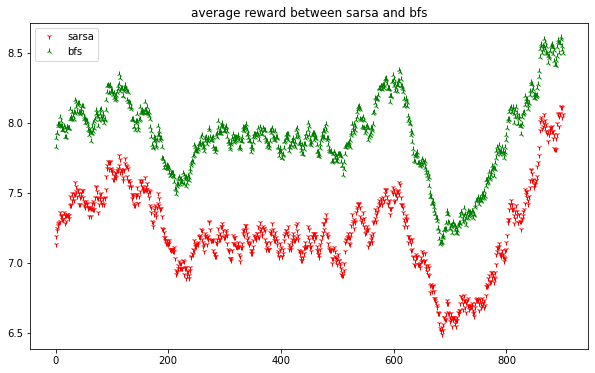

In [51]:
bfs_reward_array = []
sarsa_reward_array = []

for i in tqdm(range(1000)):
    s0 = taxi.reset()
    done = False
    total_reward = 0
    bfs_reward_array.append(return_reward_from_bfs(s0))

    while not done:
        a0 = np.argmax(estimated_returns_sarsa.loc[s0].values)
        s1, reward, done, prob_dict = taxi.step(a0)
        total_reward += reward
        if (reward == -10):
            assert 'illegal step taken, train more'
            #taxi.render()
        s0 = s1

    sarsa_reward_array.append(total_reward)

plt.figure(figsize=(10,6))
plt.title('average reward between sarsa and bfs')
sarsa_rewards_np_array = np.array(sarsa_reward_array, dtype = np.float)
sarsa_average_rewards = np.convolve(sarsa_rewards_np_array.flatten(), np.ones(100), mode = 'valid')
sarsa_average_rewards /= 100

bfs_rewards_np_array = np.array(bfs_reward_array, dtype = np.float)
bfs_average_rewards = np.convolve(bfs_rewards_np_array.flatten(), np.ones(100), mode = 'valid')
bfs_average_rewards /= 100
plt.plot(sarsa_average_rewards, 'r1')
plt.plot(bfs_average_rewards, 'g2')
plt.legend(['sarsa', 'bfs'])

## Comparison with BFS

QLearn average reward is exactly same as BFS and SARSA with the same hyper-parameters doesn't perform good enough

## Comparison of Hyper-parameters for Q-Learning

From the graph of average-reward, after 4000 episodes, average reward didn't change much. So will try with 4000 episodes



  0%|          | 2/4000 [00:00<11:01,  6.04it/s]Iteration : 15
Error: 0.04057846303402667
 13%|█▎        | 505/4000 [00:45<01:52, 31.12it/s]Iteration : 15
Error: 0.001967778764238879
 25%|██▌       | 1010/4000 [00:56<00:41, 71.28it/s]Iteration : 15
Error: 0.000948141122589492
 38%|███▊      | 1515/4000 [01:02<00:27, 90.94it/s]Iteration : 15
Error: 1.729740573944009e-05
 50%|█████     | 2012/4000 [01:07<00:18, 107.84it/s]Iteration : 15
Error: 0.00020152311491011162
 63%|██████▎   | 2520/4000 [01:11<00:13, 109.44it/s]Iteration : 15
Error: 7.558901662957876e-05
 76%|███████▌  | 3020/4000 [01:16<00:09, 103.39it/s]Iteration : 15
Error: 2.771647726144503e-14
 88%|████████▊ | 3516/4000 [01:21<00:04, 107.13it/s]Iteration : 15
Error: 0.0002925146539813402
100%|██████████| 1000/1000 [00:01<00:00, 705.72it/s]


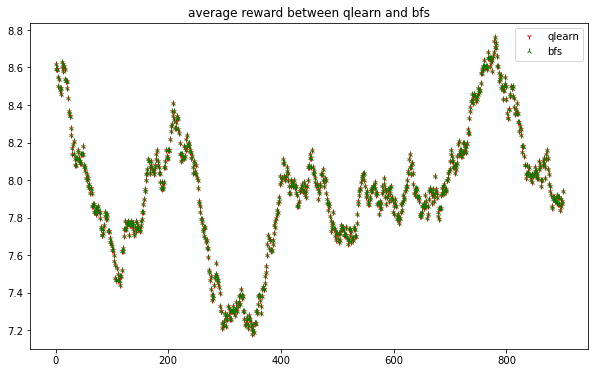

In [22]:
estimated_returns_qlearn, error_qlearn, rewards_array_qlearn = Qlearn_estimated_returns_function(4000, alpha = 0.2, gamma = 0.9)
compare_bfs_with_qlearn(estimated_returns_qlearn, 1000)

  0%|          | 3/3000 [00:00<06:21,  7.87it/s]Iteration : 15
Error: 0.036980335616
 17%|█▋        | 510/3000 [00:37<01:12, 34.37it/s]Iteration : 15
Error: 0.0027386228484595986
 34%|███▍      | 1015/3000 [00:47<00:26, 74.86it/s]Iteration : 15
Error: 0.0007405428060894281
 50%|█████     | 1509/3000 [00:52<00:14, 103.50it/s]Iteration : 15
Error: 0.0002902394191338139
 67%|██████▋   | 2017/3000 [00:57<00:08, 118.45it/s]Iteration : 15
Error: 0.00018529591970640528
 84%|████████▎ | 2512/3000 [01:01<00:04, 114.40it/s]Iteration : 15
Error: 8.865826219288163e-06
100%|██████████| 1000/1000 [00:01<00:00, 625.00it/s]


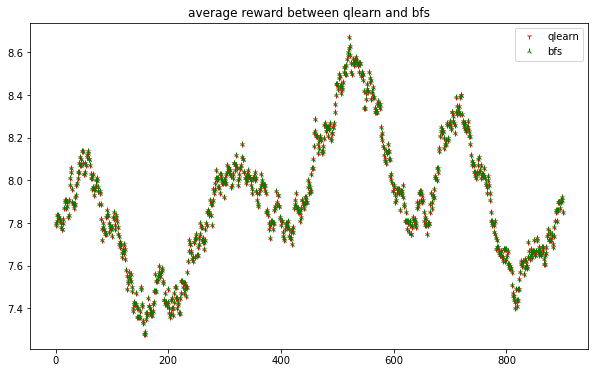

In [24]:
estimated_returns_qlearn, error_qlearn, rewards_array_qlearn = Qlearn_estimated_returns_function(3000, alpha = 0.2, gamma = 0.9)
compare_bfs_with_qlearn(estimated_returns_qlearn, 1000)

100%|██████████| 1000/1000 [00:01<00:00, 676.14it/s]


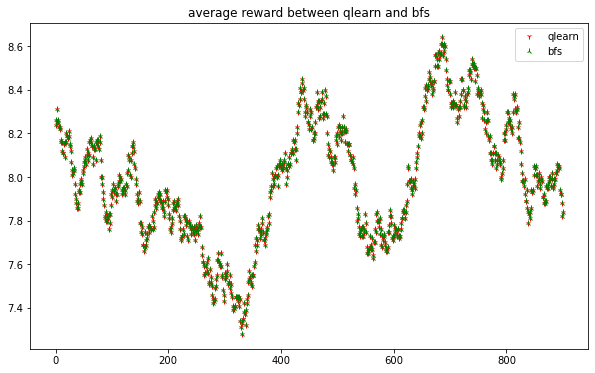

In [37]:
compare_bfs_with_qlearn(estimated_returns_qlearn, 1000)

In [21]:
estimated_returns_qlearn_2, error_qlearn_2, rewards_array_qlearn_2 = Qlearn_estimated_returns_function(3000, alpha = 0.2, gamma = 0.9)
estimated_returns_qlearn_3, error_qlearn_3, rewards_array_qlearn_3 = Qlearn_estimated_returns_function(3000, alpha = 0.3, gamma = 0.9)
estimated_returns_qlearn_4, error_qlearn_4, rewards_array_qlearn_4 = Qlearn_estimated_returns_function(3000, alpha = 0.4, gamma = 0.9)

  0%|          | 1/3000 [00:00<13:08,  3.80it/s]Iteration : Legend
Error: 0.04562567466666667
 17%|█▋        | 503/3000 [01:40<04:00, 10.40it/s]Iteration : Legend
Error: 0.0020214998902988537
 34%|███▎      | 1011/3000 [02:01<00:43, 45.76it/s]Iteration : Legend
Error: 0.0010508680381576493
 50%|█████     | 1506/3000 [02:12<00:33, 45.21it/s]Iteration : Legend
Error: 0.0001412797369243025
 67%|██████▋   | 2013/3000 [02:22<00:17, 57.89it/s]Iteration : Legend
Error: 7.910704682223138e-05
 84%|████████▎ | 2510/3000 [02:30<00:07, 64.17it/s]Iteration : Legend
Error: 0.00011839810807518571
  0%|          | 1/3000 [00:00<10:44,  4.65it/s]Iteration : Legend
Error: 0.04434478086356
 17%|█▋        | 504/3000 [01:18<03:10, 13.08it/s]Iteration : Legend
Error: 0.006714309747844686
 34%|███▎      | 1009/3000 [01:41<00:33, 58.83it/s]Iteration : Legend
Error: 6.387424581158779e-05
 50%|█████     | 1511/3000 [01:57<00:34, 43.45it/s]Iteration : Legend
Error: 0.0002901098820146833
 67%|██████▋   | 2009/300

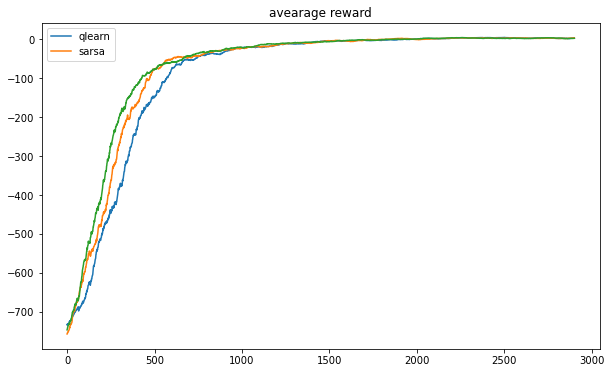

In [22]:
plt.figure(figsize=(10,6))
plt.title('avearage reward')
rewards_array_qlearn_2 = np.array(rewards_array_qlearn_2, dtype = np.float)
rewards_array_qlearn_2 = np.convolve(rewards_array_qlearn_2.flatten(), np.ones(100), mode = 'valid')
rewards_array_qlearn_2 /= 100
rewards_array_qlearn_3 = np.array(rewards_array_qlearn_3, dtype = np.float)
rewards_array_qlearn_3 = np.convolve(rewards_array_qlearn_3.flatten(), np.ones(100), mode = 'valid')
rewards_array_qlearn_3 /= 100
rewards_array_qlearn_4 = np.array(rewards_array_qlearn_4, dtype = np.float)
rewards_array_qlearn_4 = np.convolve(rewards_array_qlearn_4.flatten(), np.ones(100), mode = 'valid')
rewards_array_qlearn_4 /= 100
plt.plot(rewards_array_qlearn_2)
plt.plot(rewards_array_qlearn_3)
plt.plot(rewards_array_qlearn_4)
plt.legend(['alpha=0.2', 'alpha=0.3', 'alpha=0'])